In [ ]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm

import torchvision.models as models
from torch.nn import Module, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision

#from pytorchtools import EarlyStopping

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from torchvision import datasets, models, transforms
import time
import logging

#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV



In [26]:
from scipy.stats import pearsonr

In [27]:
train_transforms = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.5),
                                    transforms.ToTensor()])


val_transforms= transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor()])

                      

In [29]:

train_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/train/', train_transforms) 
val_dataset= datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/val/', val_transforms) 


batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader= torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)


In [30]:
dropout=0.5

In [31]:
class VGG_19_Regression(Module):
    
    def __init__(self,dropout=0.8):
        
        
        model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn',weights = None)
        
        super(VGG_19_Regression,self).__init__()
        self.model= model
        self.Regression = nn.Linear(1000,1)
        self.Batch=nn.BatchNorm1d(1000)
        #self.Flatten=nn.Flatten()
        self.dropout = Dropout(float(dropout))
        
           
         
    def forward(self, out):
        
      
        x= self.model(out)
        
        x=self.Batch(x)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.dropout(x)
        
        
        
        x =self.Regression(x) 
        
        
        return x

In [32]:
Model= VGG_19_Regression()
MSE = torch.nn.MSELoss()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.00001,momentum=0.9, weight_decay=1e-5)


Using cache found in /Users/eudari01/.cache/torch/hub/pytorch_vision_v0.10.0


In [33]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    Model = nn.DataParallel(Model)
    
torch.manual_seed(42)
#Model.to(device)    

In [34]:
#reset the parameters 
for layer in Model.children():
    if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()    
        

In [35]:
val_loss=[]
train_loss=[]

r2_score_t=[]
r2_score_v= []
                
def training(epochs):

      
                           
        Model.train()              
        epoch_loss = 0.0
        running_loss_train=0.0
   
        for inputs, label in tqdm(train_loader):
        
                  inputs= inputs.to(device)
                  label = label.to(device)
                
                
                  label= label.to(torch.float32)
    
                  label = label.unsqueeze(1)
                  #Clear the gradients
                  optimizer.zero_grad()
            
                  output = Model(inputs)
       
                  loss = MSE(output,label)
        
                  loss.backward()
                
                # Update Weights
                  optimizer.step()
                
               #Calculate prediction
                  prediction_train=output.argmax(dim=1)

        
                  running_loss_train =+ loss.item() 
          
            
                  epoch_loss += running_loss_train / len(train_loader)
                  
                   
                  r2_score_train=r2_score(label,prediction_train)
    
            
      

    
        Model.eval()
        epoch_val_loss = 0.0
        running_loss_val= 0.0
       
        
        with torch.no_grad():
        
            for inputs, label in valid_loader:
                
                        
                        inputs= inputs.to(device)
                        label = label.to(device)
                        
                        
                        label= label.to(torch.float32)
                        label = label.unsqueeze(1)

                        output = Model(inputs)
                
                        loss = MSE(output, label)
                
           
                        prediction_val= output.argmax(dim=1)
                
                        running_loss_val =+ loss.item()* inputs.size(0)
               
                #Epoch  
                    
                        epoch_val_loss += running_loss_val / len(valid_loader)
                        
                        r2_score_val= r2_score( label,prediction_val)
                    
  
         
        val_loss.append(epoch_val_loss)
        train_loss.append(epoch_loss)
        r2_score_t.append(r2_score_train)
        r2_score_v.append(r2_score_val)
        
        #save the model for the aggregation for each fold 
        torch.save(Model, 'model_weights.pt')     
    
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} -r2_score_train:{r2_score_train:.4f}-r2_score_val:{r2_score_val:.4f}\n")
        
                

        #results_df= pd.DataFrame(list(zip(epoch_loss,i)), columns= ['train_loss','split'])
        #results_df= pd.DataFrame(zip(epoch_loss,[epoch_val_loss]), columns= ['train_loss', 'val_loss'])

        
        return  train_loss, val_loss,r2_score_t,r2_score_v



In [ ]:
epochs=10
for epoch in range(1,epochs+1):
      training(epoch)
     



  4%|█▋                                          | 1/27 [00:05<02:21,  5.44s/it]

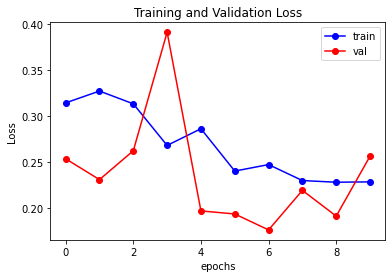

In [42]:
fig, ax1 = plt.subplots()
ax1.plot(train_loss, 'bo-',label="train")
ax1.plot(val_loss, 'ro-',label="val")
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss")
ax1.set_title("split_0_Training and Validation Loss")
fig.savefig('/path/overfit_new_plot0_CIN_.png')
plt.sho()

In [ ]:
fig1, ax2 = plt.subplots()
ax2.plot(r2_score_t, 'bo-',label="train")
ax2.plot(r2_score_v, 'ro-',label="val")
ax2.set_xlabel("epochs")
ax2.set_ylabel("R2_score")
ax2.set_title("split_0_R2_score")
fig1.savefig('/pathR2score_plot0_CIN_.png')

                                                    